In [8]:
import cymetric as cym
import pandas as pd
import sklearn as skl

import numpy as np
import sklearn as skl
import random
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (40,24)
from cymetric import graphs as cgr
from cymetric import timeseries as tm
from cymetric import filters as fl

RuntimeError: Unable to create/open database 

Exception ignored in: 'cyclus.lib._Recorder.__dealloc__'
Traceback (most recent call last):
  File "lib.pyx", line 432, in cyclus.lib._Recorder.close
RuntimeError: Unable to create/open database 


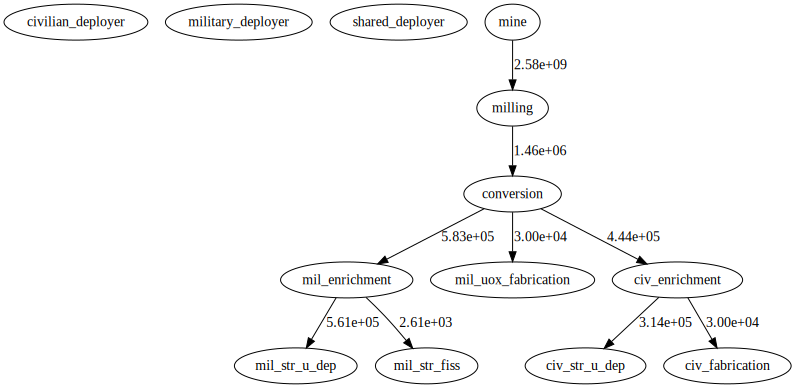

In [9]:
file = "swu_cycle_variance/out-run7.py-.sqlite"
db = cym.dbopen(file)
ev = cym.Evaluator(db=db, write=True)
cym.graphs.flow_graph(ev, label = "mass")

#### extract data from the sqlite file

In [10]:
def tidy_df(file):
    db = cym.dbopen(file)
    ev = cym.Evaluator(db=db, write=True)
    
    agentTable = ev.eval("AgentEntry")
    agents = agentTable.loc[:, ["AgentId", "Prototype"]]
    
    transTable = ev.eval("Transactions")
    transactions = transTable.loc[:, ["SenderId", "ReceiverId", "ResourceId", "Commodity", "Time"]]
    
    resourceTable = ev.eval("Resources")
    resources = resourceTable.loc[:, ["ResourceId", "Quantity"]]
    
    #merge agents, transactions, and resources
    int1 = pd.merge(transactions, resources, on='ResourceId', how='inner')

    #rename AgentId column to facilitate merge 
    send = agents.rename(columns = {"AgentId": "SenderId"})
    receive = agents.rename(columns = {"AgentId": "ReceiverId"})

    for i in range(len(int1)):
        for j in range(len(send)):
            if int1.loc[i,"SenderId"] == send.loc[j, "SenderId"]:
                int1.loc[i,"SenderId"] = send.loc[j, "Prototype"]
                
    for i in range(len(int1)):
        for j in range(len(receive)):
            if int1.loc[i,"ReceiverId"] == receive.loc[j, "ReceiverId"]:
                int1.loc[i,"ReceiverId"] = receive.loc[j, "Prototype"]

    
    return int1
    

#### trim resource-identifying columns

In [11]:
def trim_data(df):
    trimmed = df[["SenderId", "ReceiverId", "Time", "Quantity"]]
    trimmed["fraction"] = pd.Series(0, index = range(316)) #modular? 
    trimmed["truck"] = pd.Series(0, index = range(316))
    
    #assume leu and heu enrichment happens in the same physical facility
    #drop rows with transactions between enrichment facilities
    short = trimmed.loc[(trimmed['SenderId'] != "LEUenrich") & (trimmed['ReceiverId'] != "LEUtoHEUenrich")]
    
    #change the name of enrichment facilites 
    short["SenderId"] = short['SenderId'].replace({'LEUenrich': 'enrichment', 'LEUtoHEUenrich': 'enrichment'})
    short['ReceiverId'] = short['ReceiverId'].replace({'LEUenrich': 'enrichment', 'LEUtoHEUenrich': 'enrichment'})
    
    return short

#### define truck

for each transaction, cap shipment at a certain mass m ( = 25000kg? is realisitc, but a smaller value might be more interesting)
create a new column with the number of trucks sent for this interaction (0 + )
consider storing heu for several timesteps


In [12]:
from collections import Counter
def send_trucks(truck_df, truck_size): 
    truck_df["fraction"] = truck_df["Quantity"] / truck_size #reevaluate this if you want the trucks to have different capacities
    
    #collect set of all transaction types: 
    transaction_pairs = Counter()
    for i in range(len(truck_df)): 
        #add this transaction to the counter
        #check if the value for that type of transaction is greater than the value for the truck 
        #if so, send a truck and update the value for the transaction type
        #if not, update the value for the transaction type 
        #0: senderid, 1: receiverid, 2: time, 3: quantity, 4: fraction, 5: truck
        sender = truck_df.iloc[i, 0]
        receiver = truck_df.iloc[i, 1]
        transaction_pairs.update({(sender, receiver): truck_df.iloc[i, 3]})
        stored_material = transaction_pairs[(sender, receiver)]
        if stored_material >= truck_size: 
            trucks = stored_material // truck_size
            truck_df.at[i, "truck"] = trucks
            transaction_pairs[(sender, receiver)] -= trucks * truck_size
        else: 
            truck_df.at[i, "truck"] = 0
        
            
    print(transaction_pairs)
    print(truck_df)
        
    return truck_df
    

#### flatten data into single row for use with other runs

columns: every perumutation of transaction (truck boolean), every timestamp

row: single cyclus run 

transactions: mine to enrichment, enrichment to reactor, reactor to sf sink, enrichment to heu sink

In [13]:
def make_cols(max_time):
    col_names = ["diversion"]
    #transactions = ["mine--enrich", "enrich--reactor", "enrich--heusink", "reactor--sfsink"]
#         ('milling', 'conversion'),('mil_enrichment', 'mil_str_u_dep'),('civ_enrichment', 'civ_str_u_dep'), 
#         ('conversion', 'mil_uox_fabrication'), ('civ_enrichment', 'civ_fabrication'), 
#         ('mine', 'milling'), ('conversion', 'civ_enrichment'), ('mil_enrichment', 'mil_str_fiss'), 
#         ('conversion', 'mil_enrichment')
    transactions = {
          ('civ_enrichment', 'civ_str_u_dep'), ('mine', 'milling'), ('milling', 'conversion'), 
          ('civ_enrichment', 'civ_fabrication'), ('conversion', 'civ_enrichment')
    }
    
    for t in range(max_time):
        for trans in sorted(transactions): 
            col_names.append(trans[0] + "--" + trans[1] + "|time" + str(t))
    return col_names
 
def make_row(truckdf, max_time):
    long_row = []
    long_row.append("mil_enrichment" in truckdf["SenderId"].tolist())
    # mil_enrichment
#         ('milling', 'conversion'),('mil_enrichment', 'mil_str_u_dep'),('civ_enrichment', 'civ_str_u_dep'), 
#         ('conversion', 'mil_uox_fabrication'), ('civ_enrichment', 'civ_fabrication'), 
#         ('mine', 'milling'), ('conversion', 'civ_enrichment'), ('mil_enrichment', 'mil_str_fiss'), 
#         ('conversion', 'mil_enrichment')
    transactions = {
          ('civ_enrichment', 'civ_str_u_dep'), ('mine', 'milling'), ('milling', 'conversion'), 
          ('civ_enrichment', 'civ_fabrication'), ('conversion', 'civ_enrichment')
    }
    sorted_trans = sorted(transactions)
    for t in range(max_time):
        #subset rows with this timestep
        subset = truckdf.loc[truckdf['Time'] == t]
        sub_row = [0] * len(transactions)
        
        for index, row in subset.iterrows():
            #check each possible transaction
            for t in range(len(transactions)): 
                if row["SenderId"] == sorted_trans[t][0] and row["ReceiverId"] == sorted_trans[t][1]:    
                    sub_row[t] = truckdf.loc[index, "truck"]
#             if row["SenderId"] == "UraniumMine" and row["ReceiverId"] == "enrichment":
#                 #sub_row[0] = ("mine--enrich") #switch to the number of trucks sent!
#                 sub_row[0] = truckdf.loc[index, "truck"]
                
#             if row["SenderId"] == "enrichment" and row["ReceiverId"] == "reactor":
#                 sub_row[1] = truckdf.loc[index, "truck"]

#             if row["SenderId"] == "enrichment" and row["ReceiverId"] == "HEUSink":
#                 sub_row[2] = truckdf.loc[index, "truck"]

#             if row["SenderId"] == "reactor" and row["ReceiverId"] == "SpentFuelSink":
#                 sub_row[3] = truckdf.loc[index, "truck"]
        long_row.extend(sub_row)
    return long_row

In [14]:
def file_to_line(filename, truck_size, max_time):
    return make_row(send_trucks(trim_data(tidy_df(filename)), truck_size), max_time)
    
def simulation_data(files, truck_size, max_time):
    columns = make_cols(max_time)
    rows = []
    for file in files: 
        rows.append(file_to_line(file, truck_size, max_time))
    return pd.DataFrame(data = rows, columns = columns)

In [15]:
simulation_data(["0309base.sqlite", "0309reactor4.sqlite"], 12000, 144)

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/local/Library/Frameworks/Python.framework/Versions/3.6

Counter({('reactor', 'SpentFuelSink'): 6900.0, ('enrichment', 'HEUSink'): 292.86510590858416, ('UraniumMine', 'enrichment'): 0.0})
        SenderId  ReceiverId  Time      Quantity  fraction  truck
0    UraniumMine  enrichment   0.0  10000.000000  0.833333    0.0
1    UraniumMine  enrichment   1.0  10000.000000  0.833333    1.0
3     enrichment     HEUSink   2.0      4.124861  0.000344    1.0
4    UraniumMine  enrichment   2.0  10000.000000  0.833333    1.0
5    UraniumMine  enrichment   3.0  10000.000000  0.833333    0.0
..           ...         ...   ...           ...       ...    ...
213          NaN         NaN   NaN           NaN       NaN    1.0
218          NaN         NaN   NaN           NaN       NaN    0.0
219          NaN         NaN   NaN           NaN       NaN    0.0
223          NaN         NaN   NaN           NaN       NaN    1.0
227          NaN         NaN   NaN           NaN       NaN    1.0

[292 rows x 6 columns]
Counter({('reactor', 'SpentFuelSink'): 6900.0, ('Uran

,diversion,civ_enrichment--civ_fabrication|time0,civ_enrichment--civ_str_u_dep|time0,conversion--civ_enrichment|time0,milling--conversion|time0,mine--milling|time0,civ_enrichment--civ_fabrication|time1,civ_enrichment--civ_str_u_dep|time1,conversion--civ_enrichment|time1,milling--conversion|time1,...,civ_enrichment--civ_fabrication|time142,civ_enrichment--civ_str_u_dep|time142,conversion--civ_enrichment|time142,milling--conversion|time142,mine--milling|time142,civ_enrichment--civ_fabrication|time143,civ_enrichment--civ_str_u_dep|time143,conversion--civ_enrichment|time143,milling--conversion|time143,mine--milling|time143
0,False,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,False,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
import os
files = []
for file in os.listdir("swu_cycle_variance"):
    if file.endswith(".sqlite"):
        files.append(os.path.join("swu_cycle_variance", file))

#big_df = simulation_data(files[0:], 20000, 144)
#small_df = simulation_data(files[0:20], 20000, 144)
med_df = simulation_data(files[0:100], 20000, 144)

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390616, ('mine', 'milling'): 10681.13232280314, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640798883, ('conversion', 'civ_enrichment'): 3902.439024390609, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1           milling      conversion     2  1.500000e+05      7.500000      7
2              mine         milling     2  1.515152e+08   7575.757576   7575
3           milling      conversion     3  1.500000e+05      7.500000      8
4              mine         milling     3  1.851749e+08   9258.744498   9259
..              ...             ...   ...           ...           ...    ...
249      

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390354, ('milling', 'conversion'): 10406.504065040848, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 7029.686141401529, ('conversion', 'civ_enrichment'): 3902.4390243903617})
          SenderId      ReceiverId  Time      Quantity      fraction  truck
0             mine         milling     1  2.000000e+08  10000.000000  10000
1             mine         milling     2  1.515152e+08   7575.757576   7575
2          milling      conversion     2  1.500000e+05      7.500000      7
3             mine         milling     3  1.851749e+08   9258.744498   9259
4          milling      conversion     3  1.500000e+05      7.500000      8
..             ...             ...   ...           ...           ...    ...
74      conversion  civ_enrichment   134  1.640049e+04      0.820025      1
75  civ_enrichment   civ_str_u_dep   134  1.496981e+04      0.748491      1
76            mine         milling   135  5.252202e+07   262

Counter({('conversion', 'mil_enrichment'): 19607.06533681431, ('milling', 'conversion'): 19308.19971064299, ('mil_enrichment', 'mil_str_u_dep'): 18329.03973159586, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024391031, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('mine', 'milling'): 5907.82141661644, ('conversion', 'civ_enrichment'): 3902.439024391024, ('mil_enrichment', 'mil_str_fiss'): 1296.2831138644128})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...         

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1             mine          milling     2  1.515152e+08   7575.757576   7575
2          milling       conversion     2  1.500000e+05      7.500000      7
3             mine          milling     3  1.851749e+08   9258.744498   9259
4          milling       conversion     3  1.500000e+05      7.500000      8
5             mine          milling     4  1.627558e+08   8137.788814   8138
6          milling       conversion     4  1.020202e+05      5.101010      5
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390595, ('mine', 'milling'): 10681.132322758436, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640798846, ('conversion', 'civ_enrichment'): 3902.4390243905873, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...
257    

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390616, ('mine', 'milling'): 10681.13232280314, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640798883, ('conversion', 'civ_enrichment'): 3902.439024390609, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...
255      

Counter({('milling', 'conversion'): 16585.750935664662, ('conversion', 'mil_enrichment'): 16177.127654121068, ('mil_enrichment', 'mil_str_u_dep'): 15646.106223372108, ('civ_enrichment', 'civ_str_u_dep'): 13902.43902438858, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'mil_uox_fabrication'): 10000.0, ('mine', 'milling'): 5485.102615594864, ('conversion', 'civ_enrichment'): 3902.439024388579, ('mil_enrichment', 'mil_str_fiss'): 538.6074511883216})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...      

Counter({('mine', 'milling'): 18642.946930214763, ('civ_enrichment', 'civ_str_u_dep'): 13902.43902439034, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'mil_enrichment'): 6981.485197613976, ('milling', 'conversion'): 6823.855849101208, ('mil_enrichment', 'mil_str_u_dep'): 5852.58431766947, ('conversion', 'civ_enrichment'): 3902.43902439034, ('mil_enrichment', 'mil_str_fiss'): 1145.028035372278})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ...       

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.43902439031, ('milling', 'conversion'): 10406.504065040732, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.439024390311, ('mine', 'milling'): 2200.4333324581385})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000e

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.43902439042, ('milling', 'conversion'): 11878.878559455006, ('conversion', 'mil_enrichment'): 11449.790615404017, ('mil_enrichment', 'mil_str_u_dep'): 10940.376856738329, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.43902439042, ('mine', 'milling'): 3201.3835327476263, ('mil_enrichment', 'mil_str_fiss'): 516.6910980752367})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ...   

Counter({('mine', 'milling'): 16293.334583863616, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024392857, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 8401.317340111957, ('conversion', 'mil_enrichment'): 8044.06608640957, ('mil_enrichment', 'mil_str_u_dep'): 7458.803354018971, ('conversion', 'civ_enrichment'): 3902.439024392872, ('mil_enrichment', 'mil_str_fiss'): 593.6236285675066})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...     

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390907, ('mine', 'milling'): 10681.132323533297, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640799348, ('conversion', 'civ_enrichment'): 3902.4390243909074, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...
256    

Counter({('conversion', 'mil_enrichment'): 19999.999999999985, ('mil_enrichment', 'mil_str_u_dep'): 16800.445930880785, ('mine', 'milling'): 16545.855667114258, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390631, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 4676.327236014724, ('conversion', 'civ_enrichment'): 3902.439024390631, ('mil_enrichment', 'mil_str_fiss'): 3276.0102700679827})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ... 

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390893, ('mine', 'milling'): 10681.132323488593, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640799319, ('conversion', 'civ_enrichment'): 3902.4390243909, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...
261      c

Counter({('milling', 'conversion'): 19798.400344275375, ('mil_enrichment', 'mil_str_u_dep'): 16800.44593088072, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390922, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 8872.178167656064, ('conversion', 'civ_enrichment'): 3902.4390243909293, ('mil_enrichment', 'mil_str_fiss'): 3253.937243029439, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...           ...           ...   

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390136, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 7956.802909344435, ('milling', 'conversion'): 7449.041861761769, ('conversion', 'mil_enrichment'): 7435.476366851162, ('mil_enrichment', 'mil_str_u_dep'): 6487.332049009369, ('conversion', 'civ_enrichment'): 3902.439024390129, ('mil_enrichment', 'mil_str_fiss'): 961.6892366681057})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1           milling      conversion     2  1.500000e+05      7.500000      7.0
2              mine         milling     2  1.515152e+08   7575.757576   7575.0
3           milling      conversion     3  1.500000e+05      7.500000      8.0
4              mine         milling     3  1.851749e+08   9258.744498   9259.0
..              ...             ...   ...           ...     

Counter({('mil_enrichment', 'mil_str_u_dep'): 16800.4459308808, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390645, ('mine', 'milling'): 10681.132322847843, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('milling', 'conversion'): 7982.261640798912, ('conversion', 'civ_enrichment'): 3902.4390243906455, ('mil_enrichment', 'mil_str_fiss'): 3290.9698996655484, ('conversion', 'mil_enrichment'): 0.0})
           SenderId      ReceiverId  Time      Quantity      fraction  truck
0              mine         milling     1  2.000000e+08  10000.000000  10000
1              mine         milling     2  1.515152e+08   7575.757576   7575
2           milling      conversion     2  1.500000e+05      7.500000      7
3              mine         milling     3  1.851749e+08   9258.744498   9259
4           milling      conversion     3  1.500000e+05      7.500000      8
..              ...             ...   ...           ...           ...    ...
252    

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('mine', 'milling'): 17882.064377740026, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390296, ('milling', 'conversion'): 10406.504065040732, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('conversion', 'civ_enrichment'): 3902.4390243903035})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   12

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390376, ('milling', 'conversion'): 10406.50406504082, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.4390243903763, ('mine', 'milling'): 3280.72628813982})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000e+

Counter({('milling', 'conversion'): 18018.073669048492, ('conversion', 'mil_enrichment'): 17789.590921125975, ('mil_enrichment', 'mil_str_u_dep'): 17068.367595845408, ('civ_enrichment', 'civ_str_u_dep'): 13902.439024390376, ('conversion', 'mil_uox_fabrication'): 10000.0, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('mine', 'milling'): 6120.0152878165245, ('conversion', 'civ_enrichment'): 3902.4390243903617, ('mil_enrichment', 'mil_str_fiss'): 731.5265156416582})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...    

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390322, ('milling', 'conversion'): 10406.50406504076, ('civ_enrichment', 'civ_fabrication'): 9999.999999999998, ('mine', 'milling'): 4791.524850964546, ('conversion', 'civ_enrichment'): 3902.4390243903254})
          SenderId     ReceiverId  Time      Quantity      fraction  truck
0             mine        milling     1  2.000000e+08  10000.000000  10000
1             mine        milling     2  1.515152e+08   7575.757576   7575
2          milling     conversion     2  1.500000e+05      7.500000      7
3             mine        milling     3  1.851749e+08   9258.744498   9259
4          milling     conversion     3  1.500000e+05      7.500000      8
..             ...            ...   ...           ...           ...    ...
64  civ_enrichment  civ_str_u_dep   132  1.206029e+04      0.603014      0
65            mine        milling   133  6.290439e+07   3145.219551   3146
66         milling     conversion   133  1.542295e+03      0

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390325, ('milling', 'conversion'): 10406.504065040775, ('civ_enrichment', 'civ_fabrication'): 10000.0, ('mine', 'milling'): 4893.840842813253, ('conversion', 'civ_enrichment'): 3902.4390243903326})
          SenderId       ReceiverId  Time      Quantity      fraction  truck
0             mine          milling     1  2.000000e+08  10000.000000  10000
1          milling       conversion     2  1.500000e+05      7.500000      7
2             mine          milling     2  1.515152e+08   7575.757576   7575
3          milling       conversion     3  1.500000e+05      7.500000      8
4             mine          milling     3  1.851749e+08   9258.744498   9259
5          milling       conversion     4  1.020202e+05      5.101010      5
6             mine          milling     4  1.627558e+08   8137.788814   8138
7             mine          milling     5  1.215940e+08   6079.700717   6079
8       conversion   civ_enrichment   121  1.000000

Counter({('civ_enrichment', 'civ_str_u_dep'): 13902.439024390704, ('mine', 'milling'): 10119.611860826612, ('civ_enrichment', 'civ_fabrication'): 10000.000000000002, ('conversion', 'mil_uox_fabrication'): 10000.0, ('conversion', 'civ_enrichment'): 3902.439024390711, ('conversion', 'mil_enrichment'): 3360.656178141573, ('mil_enrichment', 'mil_str_fiss'): 2519.0681161563457, ('milling', 'conversion'): 1920.000115427756, ('mil_enrichment', 'mil_str_u_dep'): 877.0678946071312})
           SenderId      ReceiverId  Time      Quantity      fraction    truck
0              mine         milling     1  2.000000e+08  10000.000000  10000.0
1              mine         milling     2  1.515152e+08   7575.757576   7575.0
2           milling      conversion     2  1.500000e+05      7.500000      7.0
3              mine         milling     3  1.851749e+08   9258.744498   9259.0
4           milling      conversion     3  1.500000e+05      7.500000      8.0
..              ...             ...   ...      

In [20]:
print(med_df.shape)

(100, 721)


In [11]:
med_df.interpolate(method='linear', limit_direction='forward', axis=0)
med_df.head()

,diversion,civ_enrichment--civ_fabrication|time0,civ_enrichment--civ_str_u_dep|time0,conversion--civ_enrichment|time0,milling--conversion|time0,mine--milling|time0,civ_enrichment--civ_fabrication|time1,civ_enrichment--civ_str_u_dep|time1,conversion--civ_enrichment|time1,milling--conversion|time1,...,civ_enrichment--civ_fabrication|time142,civ_enrichment--civ_str_u_dep|time142,conversion--civ_enrichment|time142,milling--conversion|time142,mine--milling|time142,civ_enrichment--civ_fabrication|time143,civ_enrichment--civ_str_u_dep|time143,conversion--civ_enrichment|time143,milling--conversion|time143,mine--milling|time143
0,True,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,1812.0,0,0,0,1.0,0.0
1,False,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0,0,0,0.0,0.0
2,False,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,0.0,0,0,0,0.0,0.0
3,True,0,0,0,0,0,0,0,0,0,...,0,0,0,1.0,1031.0,0,0,0,0.0,848.0
4,True,0,0,0,0,0,0,0,0,0,...,0,0,0,0.0,364.0,0,0,0,0.0,367.0


In [12]:
print(sum(med_df["diversion"]))
med_df.describe()

53


,civ_enrichment--civ_fabrication|time0,civ_enrichment--civ_str_u_dep|time0,conversion--civ_enrichment|time0,milling--conversion|time0,mine--milling|time0,civ_enrichment--civ_fabrication|time1,civ_enrichment--civ_str_u_dep|time1,conversion--civ_enrichment|time1,milling--conversion|time1,mine--milling|time1,...,civ_enrichment--civ_fabrication|time142,civ_enrichment--civ_str_u_dep|time142,conversion--civ_enrichment|time142,milling--conversion|time142,mine--milling|time142,civ_enrichment--civ_fabrication|time143,civ_enrichment--civ_str_u_dep|time143,conversion--civ_enrichment|time143,milling--conversion|time143,mine--milling|time143
count,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.00,100.00,100.000000,100.00000,100.0,100.0,100.00,100.000000,100.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,...,0.0,0.01,0.01,0.090000,538.64000,0.0,0.0,0.01,0.280000,169.970000
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.10,0.10,0.287623,704.62797,0.0,0.0,0.10,0.451261,286.768603
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,...,0.0,0.00,0.00,0.000000,0.00000,0.0,0.0,0.00,0.000000,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,...,0.0,0.00,0.00,0.000000,0.00000,0.0,0.0,0.00,0.000000,0.000000
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,...,0.0,0.00,0.00,0.000000,151.00000,0.0,0.0,0.00,0.000000,0.000000
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,...,0.0,0.00,0.00,0.000000,1052.00000,0.0,0.0,0.00,1.000000,263.000000
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,...,0.0,1.00,1.00,1.000000,1812.00000,0.0,0.0,1.00,1.000000,1555.000000


In [13]:
from sklearn.model_selection import train_test_split
#split into training and test sets
X = med_df.loc[:, med_df.columns != "diversion"]
y = med_df["diversion"]
trucks_train, trucks_test, diversion_train, diversion_test = train_test_split(X, y, test_size=0.3)

In [14]:
#random forest classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(trucks_train,diversion_train)

y_pred = rf.predict(trucks_test)

In [19]:
from sklearn import metrics
#check performance
print("Accuracy:",metrics.accuracy_score(diversion_test, y_pred))

features = pd.Series(rf.feature_importances_,index=med_df.columns[1:]).sort_values(ascending=False)
print(features)

Accuracy: 1.0
mine--milling|time84                      0.064054
mine--milling|time98                      0.060000
mine--milling|time124                     0.059705
mine--milling|time123                     0.050000
mine--milling|time63                      0.048259
                                            ...   
civ_enrichment--civ_fabrication|time90    0.000000
milling--conversion|time89                0.000000
conversion--civ_enrichment|time89         0.000000
civ_enrichment--civ_str_u_dep|time89      0.000000
civ_enrichment--civ_fabrication|time0     0.000000
Length: 720, dtype: float64
